In [1]:
import pandas
import numpy

from matplotlib import pyplot as plt
import seaborn as sns

#Ad A/B Testing


# Ad A/B Testing

Dataset source: [Kaggle - Ad A/B Testing](https://www.kaggle.com/datasets/osuolaleemmanuel/ad-ab-testing)

## Columns Description

- **auction_id**: The unique ID of the online user who has been presented the BIO (impression ID). If the user sees the questionnaire but doesn't respond, both yes and no columns are zero.

- **experiment**: Which group the user belongs to:

  - **control**: Users shown a dummy ad
  - **exposed**: Users shown a creative, interactive ad with the SmartAd brand

- **date**: The date in YYYY-MM-DD format

- **hour**: The hour of the day in HH format

- **device_make**: The type of device the user has (e.g. Samsung)

- **platform_os**: The ID of the operating system

- **browser**: The browser used to view the BIO questionnaire

- **yes**: 1 if user selects "Yes" in the BIO questionnaire

- **no**: 1 if user selects "No" in the BIO questionnaire


In [117]:
data = pandas.read_csv("AdSmartABdata.csv")

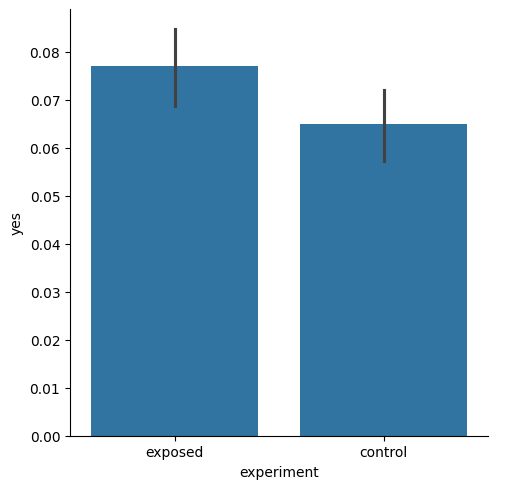

In [118]:
sns.catplot(x="experiment", y="yes", data=data, kind="bar")

### Is there a difference in the proportion of users who click on the ad between the control and exposed groups?

Judging by the plot, there seems to be a tiny difference, now is it really significant? If you were to make a decision on whether to roll out this change for good, would you?


# There is data, but where's the story?!


In [121]:
df = data.drop(columns=["auction_id", "date", "no"])

df["time_of_day"] = pandas.cut(
    df["hour"],
    bins=[0, 6, 12, 18, 24],
    labels=["night", "morning", "afternoon", "evening"],
    include_lowest=True,
)
df = df.drop(columns=["hour"])
df["platform_os"] = df["platform_os"].astype(str)
df["yes"] = df["yes"].astype(str)

In [122]:
from magpy.oracles.mixed import MixedDataOracle

oracle = MixedDataOracle(df, threshold=0.01)
print("Independent? ", oracle("experiment", "yes"))

Independent?  True


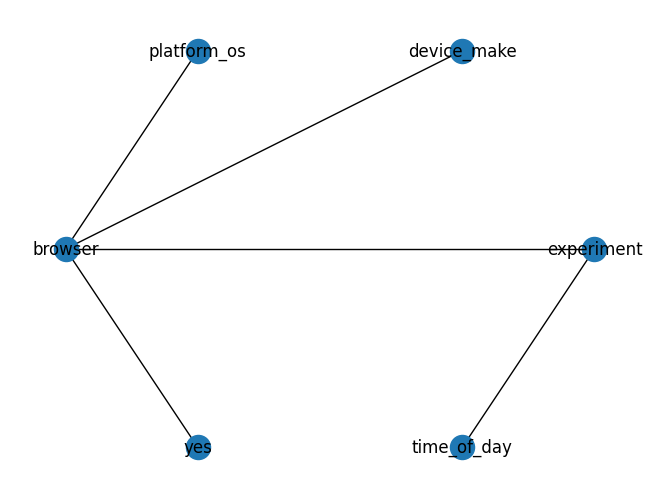

In [123]:
from magpy.search.pcskeleton import pc_skeleton
import networkx as nx

skeleton, sepsets = pc_skeleton(
    oracle, df.columns, intersection_or_union="intersection"
)

g = nx.from_pandas_adjacency(skeleton)
nx.draw_circular(g, with_labels=True)

## So what is going on, really?


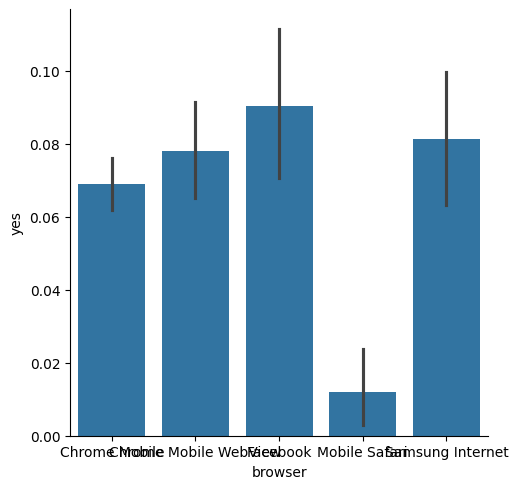

In [124]:
top_browsers = data["browser"].value_counts().iloc[:5].index.tolist()

sns.catplot(
    x="browser", y="yes", data=data[data["browser"].isin(top_browsers)], kind="bar"
)

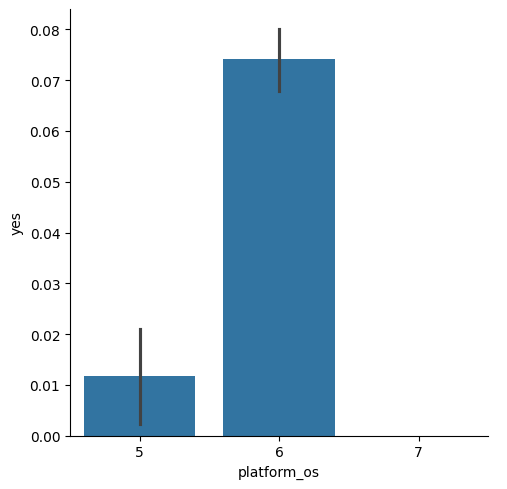

In [125]:
sns.catplot(x="platform_os", y="yes", data=data, kind="bar")

In [126]:
data[data["browser"].isin(top_browsers)].groupby(["platform_os", "browser"])[
    "yes"
].count().unstack(level=1).fillna(0)

browser,Chrome Mobile,Chrome Mobile WebView,Facebook,Mobile Safari,Samsung Internet
platform_os,,,,,
5,0.0,0.0,0.0,334.0,0.0
6,4554.0,1489.0,764.0,3.0,824.0


In [135]:
experiment_v_platform = (
    data.groupby(["platform_os", "experiment"])["yes"]
    .count()
    .unstack(level=1)
    .fillna(0)
)
(experiment_v_platform.div(experiment_v_platform.sum(axis=1), axis=0) * 100).round(2)

experiment,control,exposed
platform_os,,
5,71.96,28.04
6,49.20,50.80
7,0.00,100.00


- Users in the control group are more likely to be in **Platform OS 5** and thus use **Safari**
- These are the same group that don't really want to click yes on the ad.

The end!


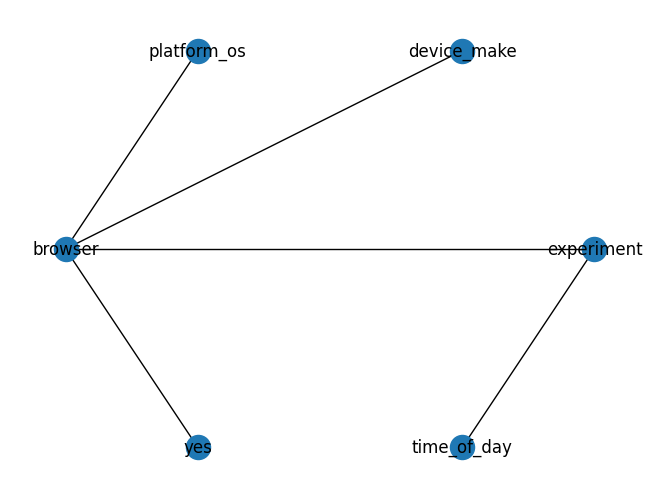

In [136]:
nx.draw_circular(g, with_labels=True)